In [1]:
from mapbuilder import MapBuilder
from invprojection import  RBFinv, Pinv_ilamp, NNinv_torch, PPinvWrapper
from sklearn.preprocessing import minmax_scale, MinMaxScaler
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.manifold import TSNE, MDS
from sklearn.linear_model import LogisticRegression
from umap import UMAP
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import time

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

/home/peyote/workspace/map_builder/mapbuilder/tools.py:66: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/peyote/workspace/map_builder/mapbuilder/tools.py:140: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/peyote/workspace/map_builder/mapbuilder/tools.py:186: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'n

# Prepare data

In [2]:
# X, y = make_blobs(n_samples=800, centers=4, n_features=30, random_state=42)
# X = minmax_scale(X)
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = np.array(X)
y = np.array(y)
X = X.astype('float32') / 255.
y = y.astype('int')
X, _, y, _ = train_test_split(X, y, train_size=3000, test_size=2000, random_state=420)
# iris = load_iris()
# X = iris.data
# y = iris.target
# X = minmax_scale(X)

# clf = LogisticRegression()
# clf.fit(X, y)

/home/peyote/.conda/envs/tf3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Build Projection $P$ and Inverse Projection $P^{-1}$

In [3]:
PPinv = PPinvWrapper(UMAP(n_components=2, random_state=0), NNinv_torch((128, 256, 512, 1024)))
# PPinv = PPinvWrapper(UMAP(n_components=2, random_state=0), RBFinv())
# PPinv = PPinvWrapper(UMAP(n_components=2, random_state=0), Pinv_ilamp())
PPinv.fit(X=X, y=y)
X2D = PPinv.transform(X)

device:  cuda:0


/home/peyote/.conda/envs/tf3.11/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epoch 1/150, Loss: 0.10927607
Epoch 2/150, Loss: 0.07057527
Epoch 3/150, Loss: 0.06784351
Epoch 4/150, Loss: 0.06350097
Epoch 5/150, Loss: 0.05974981
Epoch 6/150, Loss: 0.05711199
Epoch 7/150, Loss: 0.05469612
Epoch 8/150, Loss: 0.05281581
Epoch 9/150, Loss: 0.05152043
Epoch 10/150, Loss: 0.05041985
Epoch 11/150, Loss: 0.04945607
Epoch 12/150, Loss: 0.04856831
Epoch 13/150, Loss: 0.04782928
Epoch 14/150, Loss: 0.04721003
Epoch 15/150, Loss: 0.04667778
Epoch 16/150, Loss: 0.04620231
Epoch 17/150, Loss: 0.04577261
Epoch 18/150, Loss: 0.04534222
Epoch 19/150, Loss: 0.04492563
Epoch 20/150, Loss: 0.04456046
Epoch 21/150, Loss: 0.04421183
Epoch 22/150, Loss: 0.04387959
Epoch 23/150, Loss: 0.04359018
Epoch 24/150, Loss: 0.04330104
Epoch 25/150, Loss: 0.04303618
Epoch 26/150, Loss: 0.04279076
Epoch 27/150, Loss: 0.04258736
Epoch 28/150, Loss: 0.04237897
Epoch 29/150, Loss: 0.04216034
Epoch 30/150, Loss: 0.04197152
Epoch 31/150, Loss: 0.04179358
Epoch 32/150, Loss: 0.04163041
Epoch 33/150, Los

In [4]:
builder = MapBuilder(PPinv, None, X2d=X2D, X=X, y=y, scaling=0.9)

n_classes: 10


Loss: 1.4773: 100%|██████████| 150/150 [00:03<00:00, 44.01it/s]


# Original FastDBM for several classifiers

In [5]:
GRID = 512

clf_dict = {
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier([512, 512, 512]),
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
}

for name, clf in clf_dict.items():
    clf.fit(X, y)

In [6]:
def plot_DBMs(clf, clf_name, mapbuilder):

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    fig.subplots_adjust(wspace=0.05, hspace=0.03)

    builder = mapbuilder
    builder.clf = clf
    time0 = time.time()
    builder.plot_decision_map(ax[0],  fast=False, grid=GRID)
    time1 = time.time()
    # builder.plot_training_data(ax=ax[0])
    _, sparse = builder.plot_decision_map(ax[1],  fast=True, grid=GRID, initial_resolution=32)
    time2 = time.time()

    ax[0].text(0.04, 0.05, 'Time: {:.2f}s'.format(time1-time0), fontsize=15, color='k')
    ax[1].text(0.04, 0.05, 'Time: {:.2f}s'.format(time2-time1), fontsize=15, color='k')

    ax[0].set_title(f'DBM for {clf_name} Ground Truth')
    ax[1].set_title(f'DBM for {clf_name} Fast')

    ax[2].set_title('Binary Split Process')
    ax[2].set_aspect('equal')

    t = 0
    for item in sparse:
        if item[-2] > t and item[-1] > t:
            w, h = item[-1], item[-2]
            ax[2].add_patch(Rectangle((item[0]-w/2, item[1]-h/2), w, h, fill=None, edgecolor='r', lw=0.1))

    ax[2].set(xlim=(-1, GRID), ylim=(-1, GRID))
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    plt.show()



slow strategy
fast strategy


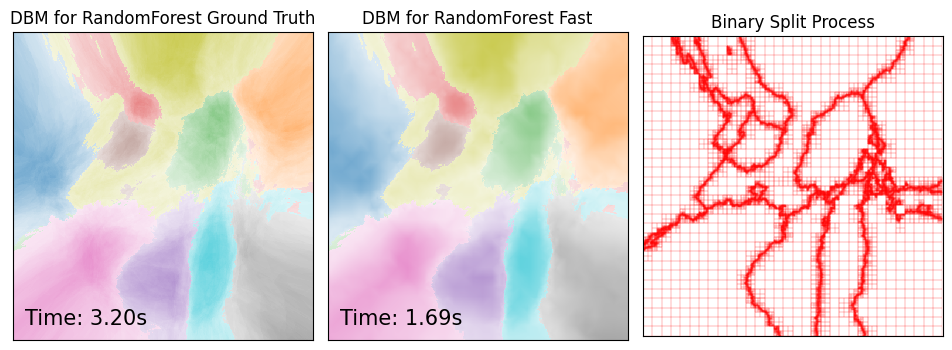

slow strategy
fast strategy


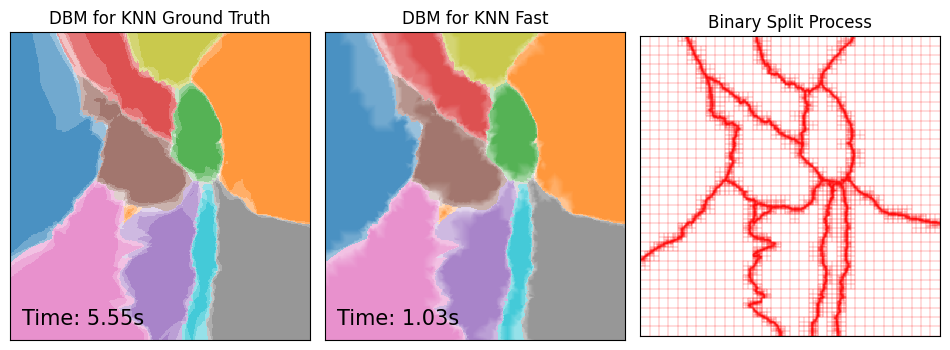

slow strategy
fast strategy


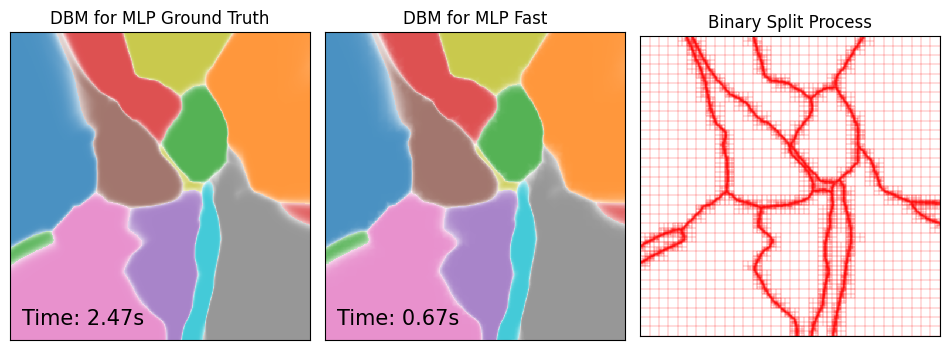

slow strategy


In [7]:
for clf_name, clf in clf_dict.items():
    plot_DBMs(clf, clf_name, builder)

# Generalized Binary Split for maps with continues values

In [ ]:
## Setttings
builder = MapBuilder(PPinv, None, X2d=X2D, X=X, y=y, scaling=0.9)
GRID = 512          ## resolution n
alpha = 0.15        ## threshold alpha, the larger the faster but less accurate. Suitable range: [0.1, 0.2]




n_classes: 10


Loss: 2.1293:   0%|          | 0/150 [00:00<?, ?it/s]

Loss: 1.4747: 100%|██████████| 150/150 [00:03<00:00, 43.40it/s]


### Distance to nearest training sample maps $D_D$

slow strategy
fast strategy
threshold_abs: 0.7030020772040146


[]

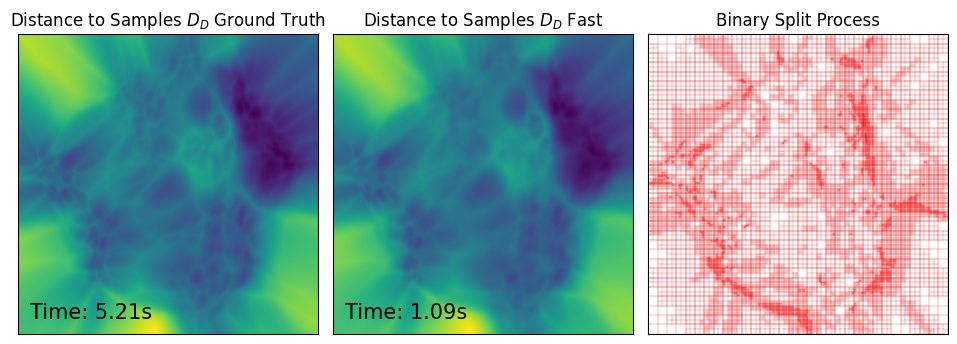

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(wspace=0.05, hspace=0.03)


time0 = time.time()
builder.plot_dist_map(ax[0],  fast=False, grid=GRID, content='nearest')
time1 = time.time()
_, sparse = builder.plot_dist_map(ax[1],  fast=True, grid=GRID, initial_resolution=32, content='nearest', threshold=0.1)
time2 = time.time()
ax[0].text(0.04, 0.05, 'Time: {:.2f}s'.format(time1-time0), fontsize=15, color='k')
ax[1].text(0.04, 0.05, 'Time: {:.2f}s'.format(time2-time1), fontsize=15, color='k')


# builder.plot_training_data(ax=ax[0])

ax[0].set_title('Distance to Samples $D_D$ Ground Truth')
ax[1].set_title('Distance to Samples $D_D$ Fast')

ax[2].set_title('Binary Split Process')
ax[2].set_aspect('equal')

t = 0
for item in sparse:
    if item[-2] > t and item[-1] > t:
        w, h = item[-1], item[-2]
        ax[2].add_patch(Rectangle((item[0]-w/2, item[1]-h/2), w, h, fill=None, edgecolor='r', lw=0.1))

ax[2].set(xlim=(-1, GRID), ylim=(-1, GRID))
ax[2].set_xticks([])
ax[2].set_yticks([])



### Gradient Maps $G$

slow strategy
fast strategy
threshold_abs: 33.19933319091797


[]

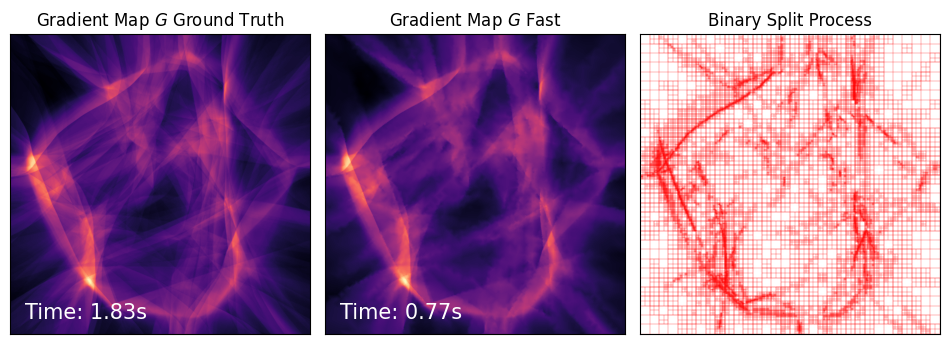

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(wspace=0.05, hspace=0.03)

time0 = time.time()
builder.plot_gradient_map(ax[0],  fast=False, grid=GRID, plot_mean=False)
time1 = time.time()

# print(time1-time0)
_, sparse = builder.plot_gradient_map(ax[1],  fast=True, grid=GRID, initial_resolution=32, threshold=alpha, plot_mean=False, reduced=True)
time2 = time.time()
# print(time2-time1)

ax[0].text(0.05, 0.05, 'Time: {:.2f}s'.format(time1-time0), fontsize=15, color='w')
ax[1].text(0.05, 0.05, 'Time: {:.2f}s'.format(time2-time1), fontsize=15, color='w')

ax[0].set_title('Gradient Map $G$ Ground Truth')
ax[1].set_title('Gradient Map $G$ Fast')


ax[2].set_title('Binary Split Process')
ax[2].set_aspect('equal')

t = 0
for item in sparse:
    if item[-2] > t and item[-1] > t:
        w, h = item[-1], item[-2]
        ax[2].add_patch(Rectangle((item[0]-w/2, item[1]-h/2), w, h, fill=None, edgecolor='r', lw=0.1))

# ax[2].axis('off')

ax[2].set(xlim=(-1, GRID), ylim=(-1, GRID))
ax[2].set_xticks([])
ax[2].set_yticks([])
# sparse

### Distance-to-decision boundary maps $D_B$

slow strategy
fast strategy
threshold_abs: 0.3325153112411499


[]

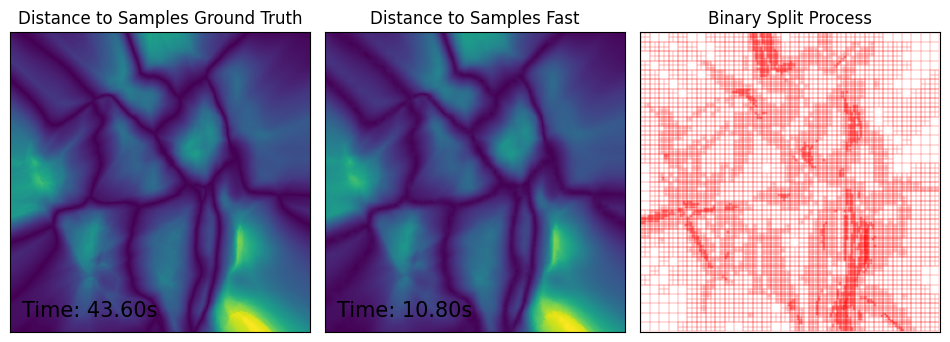

In [ ]:
GRID_D_B = 512 

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(wspace=0.05, hspace=0.03)

time0 = time.time()
builder.plot_dist_map(ax[0],  fast=False, grid=GRID_D_B, content='dist_map_general')
time1 = time.time()

_, sparse = builder.plot_dist_map(ax[1],  fast=True, grid=GRID_D_B, initial_resolution=32, content='dist_map_general', threshold=alpha)  ## reduce grid 
time2 = time.time()

ax[0].text(0.04, 0.05, 'Time: {:.2f}s'.format(time1-time0), fontsize=15, color='k')
ax[1].text(0.04, 0.05, 'Time: {:.2f}s'.format(time2-time1), fontsize=15, color='k')
# builder.plot_boundary(ax[1], grid=400, fast=fast_strategy)
# ax[2].scatter(sparse[:, 0], sparse[:, 1], c=sparse[:, 2], cmap='cividis', marker='s', s=2)


ax[0].set_title('Distance to Samples Ground Truth')
ax[1].set_title('Distance to Samples Fast')

ax[2].set_title('Binary Split Process')
ax[2].set_aspect('equal')


## plot the binary split process
t = 0
for item in sparse:
    if item[-2] > t and item[-1] > t:
        w, h = item[-1], item[-2]
        ax[2].add_patch(Rectangle((item[0]-w/2, item[1]-h/2), w, h, fill=None, edgecolor='r', lw=0.1))

ax[2].set(xlim=(-1, GRID_D_B), ylim=(-1, GRID_D_B))
ax[2].set_xticks([])
ax[2].set_yticks([])
